In [2]:
!pip install transformers==3.3.1

     |████████████████████████████████| 1.1MB 12.8MB/s 
     |████████████████████████████████| 3.0MB 57.7MB/s 
     |████████████████████████████████| 1.2MB 58.2MB/s 
     |████████████████████████████████| 890kB 47.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=d7f2dd75d99db7ba97ad16a5d9fee44459d24abe6f99151bd6b8645fabcdabf4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas
import numpy as np
from sklearn.metrics import confusion_matrix
import csv
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict, Counter
import time
from transformers import AutoModel
from torch import nn
import sys
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn')

In [4]:
filePath = "/content/drive/My Drive/MLNLP/FinalAssignment/train.csv"
filePathTest = "/content/drive/My Drive/MLNLP/FinalAssignment/test.csv"
filePathResult = "/content/drive/My Drive/MLNLP/FinalAssignment/"

In [5]:
def readData(fileName):
    # colnames = ['id', 'text', 'is_humor', 'humor_rating', 'humor_controversy', 'offense_rating']
    train_data = pandas.read_csv(fileName)
    X = train_data.text.tolist()
    Y = train_data.is_humor.tolist()
    return X, Y

def readDataTest(fileName):
    test_data = pandas.read_csv(fileName)
    xTest = test_data.text.tolist()
    return xTest  
  
def writeData(fileName, testData, resultList):
  fileHandler = open(fileName, 'w')
  with fileHandler:
    headings = ['text', 'is_humor']
    writer = csv.writer(fileHandler)
    writer.writerows(zip(testData, resultList))
    # for iResult in resultList:
    #   fileHandler.write("%s\n" % iResult)

def evaluateTest(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn)/(tp+tn+fp+fn)
    f1score = tp / (tp + 0.5*(fp + fn))
    return accuracy, f1score

In [6]:
def bert_tokenize_and_encode(tokenizer, documents, max_len):
    cls = tokenizer.cls_token_id
    sep = tokenizer.sep_token_id
    tokenized_docs = [tokenizer.tokenize(doc)[:max_len - 2] for doc in documents]
    out = [tokenizer.encode(doc) for doc in tokenized_docs]
    return out

In [7]:
class DocumentDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def __len__(self):
        return len(self.X)

class DocumentBatcher:
    def __init__(self, pad):
        self.pad = pad

    def __call__(self, XY):
        max_len = max(len(x) for x, _ in XY)
        Xpadded = torch.as_tensor([x + [self.pad]*(max_len - len(x)) for x, _ in XY])
        Y = torch.as_tensor([y for _,y in XY])
        return Xpadded, Y

In [25]:
class TextClassifier:
    def __init__(self, params, tokenizer):
        self.params = params
        self.tokenizer = tokenizer

    def epoch(self, batches, optimizer=None):
        n_correct = 0
        n_instances = 0
        total_loss = 0
        TP = 0
        TN = 0
        FP = 0
        FN = 0

        for Xbatch, Ybatch in batches:
            Xbatch = Xbatch.to(self.params.device)
            Ybatch = Ybatch.to(self.params.device)
            scores = self.model(Xbatch)  # Check what is scores
            loss = self.loss(scores, Ybatch)
            total_loss += loss.item()
            n_instances += Ybatch.shape[0]
            guesses = scores.argmax(dim=1)
            n_correct += (guesses == Ybatch).sum().item()
            for iY in Ybatch:
              if Ybatch[iY] == 1 and guesses[iY] == Ybatch[iY]:
                TP += 1
              elif Ybatch[iY] == 1:
                FN += 1
              elif Ybatch[iY] == 0 and guesses[iY] == Ybatch[iY]:
                TN += 1
              elif Ybatch[iY] == 0:
                FP += 1

            if optimizer:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return total_loss/len(batches), n_correct/n_instances, TP/(TP + 0.5*(FP + FN))

    def preprocess(self, X, Y):
        print('Preprocessing all documents...')
        Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state=0)
        self.lbl_enc = LabelEncoder()
        self.lbl_enc.fit(Ytrain)
        self.voc_size = self.tokenizer.vocab_size
        self.n_classes = len(self.lbl_enc.classes_)

        batcher = DocumentBatcher(self.tokenizer.pad_token_id)

        train_docs = bert_tokenize_and_encode(self.tokenizer, Xtrain, self.params.max_len)
        train_dataset = DocumentDataset(train_docs, self.lbl_enc.transform(Ytrain))

        self.train_loader = DataLoader(train_dataset, self.params.batch_size, shuffle=True,
                                  collate_fn=batcher)
        val_docs = bert_tokenize_and_encode(self.tokenizer, Xval, self.params.max_len)
        val_dataset = DocumentDataset(val_docs,
                                      self.lbl_enc.transform(Yval))
        self.val_loader = DataLoader(val_dataset, self.params.batch_size, shuffle=True,
                                     collate_fn=batcher)
        print('... done.')

    def set_model(self, model):
        self.model = model

    def train(self):
        par = self.params
        self.model.to(par.device)
        self.loss = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=par.eta, weight_decay=par.decay)
        self.history = defaultdict(list)
        
        epoch = 0
        self.flagEpoch = 0
        while epoch < par.n_epochs+1 and self.flagEpoch == 0:
            epoch += 1
            t0 = time.time()
            self.model.train()
            train_loss, train_acc, train_f1_score = self.epoch(self.train_loader, optimizer)
            self.model.eval()         
            with torch.no_grad():
                val_loss, val_acc, val_f1_score = self.epoch(self.val_loader)
            
            t1 = time.time()

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['train_f1'].append(train_f1_score)
            self.history['val_f1'].append(val_f1_score)
            self.history['time'].append(t1-t0)
            
            if epoch % 1 == 0:
                print(f'Epoch {epoch}: train loss:{train_loss:.4f}, train acc: {train_acc:.4f}, '
                      + f'val loss: {val_loss:.4f}, val acc: {val_acc:.4f}, time: {t1-t0:.4f}')       

            # if self.history['val_loss'][epoch - 1] - self.history['val_loss'][epoch - 2] > 0:
            #       self.flagEpoch = 1 

            flagEpochArray = np.zeros(5, dtype = int)
            if epoch > 2:
              for iEpoch in range(1,2):
                if self.history['val_loss'][epoch - iEpoch] - self.history['val_loss'][epoch - (iEpoch + 1)] > 0:
                  flagEpochArray[iEpoch - 1] = 1
            if np.sum(flagEpochArray) >= 1:
              self.flagEpoch = 1
        
    def predict(self, X):
        """Run a trained document classifier on a set of documents and return the predictions."""
        batcher = DocumentBatcher(self.tokenizer.pad_token_id)
        dummy_labels = [self.lbl_enc.classes_[0] for x in X]        

        enc_docs = bert_tokenize_and_encode(self.tokenizer, X, self.params.max_len)
        dataset = DocumentDataset(enc_docs, 
                                  self.lbl_enc.transform(dummy_labels))
        loader = DataLoader(dataset, self.params.batch_size, collate_fn=batcher)
        self.model.eval()
        output = []
        with torch.no_grad():
            for Xbatch, Ybatch in loader:
                Xbatch = Xbatch.to(self.params.device)
                Ybatch = Ybatch.to(self.params.device)
                scores = self.model(Xbatch)
                guesses = scores.argmax(dim=1)
                output.extend(self.lbl_enc.inverse_transform(guesses.cpu().numpy()))
        return output

In [26]:
class BERTEncoder(nn.Module):

    def __init__(self, model_name):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.output_size = self.bert.config.hidden_size

    def forward(self, documents):
        bert_outputs = self.bert(documents)
        top_layer_output = bert_outputs[0]
        cls_output = top_layer_output[:, 0, :]
        print('.', end='')
        sys.stdout.flush()
        return cls_output

In [27]:
class TextClassifierParametersBERT:
    device = 'cuda'
    n_epochs = 15
    batch_size = 32
    eta = 5e-5
    decay = 0
    dropout = 0.2
    max_len = 128

def main():
    global clf
    
    torch.manual_seed(0)

    X, Y = readData(filePath)
    
    bert_model_name = 'distilbert-base-uncased'
    use_bert = True
    
    if use_bert:
        params = TextClassifierParametersBERT()
    
    tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
    
    clf = TextClassifier(params, tokenizer)
    
    clf.preprocess(X, Y)
    
    if use_bert:
        encoder = BERTEncoder(bert_model_name)

    clf.set_model(nn.Sequential(
            encoder,
            nn.Dropout(params.dropout),
            nn.Linear(encoder.output_size, out_features=clf.n_classes)
    ))

    clf.train()

    return clf

bertModel = main()

Preprocessing all documents...
... done.
...........................................................................................................................................................................................................................Epoch 1: train loss:0.2901, train acc: 0.8700, val loss: 0.1900, val acc: 0.9200, time: 39.8137
...........................................................................................................................................................................................................................Epoch 2: train loss:0.1064, train acc: 0.9621, val loss: 0.1954, val acc: 0.9264, time: 40.4605
...........................................................................................................................................................................................................................Epoch 3: train loss:0.0373, train acc: 0.9884, val loss: 0.2299, val acc: 0.9336, time: 40.3577


In [28]:
finalAccBERTVal = bertModel.history['val_acc'][len(bertModel.history['val_acc']) - 1]
finalAccBERTTrain = bertModel.history['train_acc'][len(bertModel.history['train_acc']) - 1]
finalF1BERTVal = bertModel.history['val_f1'][len(bertModel.history['val_f1']) - 1]
finalF1BERTTrain = bertModel.history['train_f1'][len(bertModel.history['train_f1']) - 1]

print(f"BERT Avg Val Accuracy = {np.mean(finalAccBERTVal)}, Train Accuracy = {np.mean(finalAccBERTTrain)}")
print(f"BERT Avg Val F1 = {np.mean(finalF1BERTVal)}, Train F1 = {np.mean(finalF1BERTTrain)}")

BERT Avg Val Accuracy = 0.9335714285714286, Train Accuracy = 0.9883928571428572
BERT Avg Val F1 = 0.9513227513227513, Train F1 = 0.9921655580192166


In [29]:
XX, YY = readData(filePathTest)
resultList = bertModel.predict(XX)
fileNameRes = "BERT_classification.csv"
fileName = filePathResult + fileNameRes
writeData(fileName, XX, resultList)
testAcc, testF1 = evaluateTest(YY, resultList)
print("Test accuracy = ", testAcc)
print("Test F1 score = ", testF1)

................................Test accuracy =  0.932
Test F1 score =  0.9448946515397083


In [30]:
class TextClassifierParametersBERT:
    device = 'cuda'
    n_epochs = 15
    batch_size = 32
    eta = 5e-5
    decay = 0
    dropout = 0.2
    max_len = 128

def main():
    global clf
    
    torch.manual_seed(0)

    X, Y = readData(filePath)
    
    bert_model_name = 'xlnet-base-cased'
    use_bert = True
    
    if use_bert:
        params = TextClassifierParametersBERT()
    
    tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
    
    clf = TextClassifier(params, tokenizer)
    
    clf.preprocess(X, Y)
    
    if use_bert:
        encoder = BERTEncoder(bert_model_name)

    clf.set_model(nn.Sequential(
            encoder,
            nn.Dropout(params.dropout),
            nn.Linear(encoder.output_size, out_features=clf.n_classes)
    ))

    clf.train()

    return clf

bertModel2 = main()

Preprocessing all documents...


/usr/local/lib/python3.6/dist-packages/transformers/configuration_xlnet.py:212: FutureWarning: This config doesn't use attention memories, a core feature of XLNet. Consider setting `men_len` to a non-zero value, for example `xlnet = XLNetLMHeadModel.from_pretrained('xlnet-base-cased'', mem_len=1024)`, for accurate training performance as well as an order of magnitude faster inference. Starting from version 3.5.0, the default parameter will be 1024, following the implementation in https://arxiv.org/abs/1906.08237
  FutureWarning,


... done.
...........................................................................................................................................................................................................................Epoch 1: train loss:0.3332, train acc: 0.8695, val loss: 0.2185, val acc: 0.9114, time: 117.9629
...........................................................................................................................................................................................................................Epoch 2: train loss:0.1563, train acc: 0.9443, val loss: 0.2426, val acc: 0.9257, time: 120.0160
...........................................................................................................................................................................................................................Epoch 3: train loss:0.0782, train acc: 0.9721, val loss: 0.2116, val acc: 0.9379, time: 118.3341
..........................................

In [31]:
finalAccBERTVal = bertModel2.history['val_acc'][len(bertModel2.history['val_acc']) - 1]
finalAccBERTTrain = bertModel2.history['train_acc'][len(bertModel2.history['train_acc']) - 1]
finalF1BERTVal = bertModel2.history['val_f1'][len(bertModel2.history['val_f1']) - 1]
finalF1BERTTrain = bertModel2.history['train_f1'][len(bertModel2.history['train_f1']) - 1]

print(f"BERT Avg Val Accuracy = {np.mean(finalAccBERTVal)}, Train Accuracy = {np.mean(finalAccBERTTrain)}")
print(f"BERT Avg Val F1 = {np.mean(finalF1BERTVal)}, Train F1 = {np.mean(finalF1BERTTrain)}")

BERT Avg Val Accuracy = 0.9321428571428572, Train Accuracy = 0.9846428571428572
BERT Avg Val F1 = 0.9563294637921503, Train F1 = 0.9902169289663972


In [33]:
XX, YY = readData(filePathTest)
resultList = bertModel2.predict(XX)
fileNameRes = "XLNET_classification.csv"
fileName = filePathResult + fileNameRes
writeData(fileName, XX, resultList)
testAcc, testF1 = evaluateTest(YY, resultList)
print("Test accuracy = ", testAcc)
print("Test F1 score = ", testF1)

................................Test accuracy =  0.929
Test F1 score =  0.9430633520449078


In [36]:
def plotit_bert():
    plt.figure()
    plt.plot(bertModel.history['train_loss'], label = "TrainLoss")
    plt.plot(bertModel.history['val_loss'], label = "ValLoss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("BERT Loss-Epoch Plot")
    plt.legend()
    figName = "/content/drive/My Drive/MLNLP/FinalAssignment/BERT_class_Loss.eps"
    plt.savefig(figName)

    plt.figure()
    plt.plot(bertModel.history['train_acc'], label = "TrainAcc")
    plt.plot(bertModel.history['val_acc'], label = "ValAcc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"BERT Accuracy-Epoch Plot, Final Val Acc = {bertModel.history['val_acc'][len(bertModel.history['val_acc']) - 1]:.2f}, Final Train Acc = {bertModel.history['train_acc'][len(bertModel.history['train_acc']) - 1]:.2f}")
    plt.legend()
    figName = "/content/drive/My Drive/MLNLP/FinalAssignment/BERT_class_Acc.eps"
    plt.savefig(figName)

    plt.figure()
    plt.plot(bertModel.history['train_f1'], label = "trainF1")
    plt.plot(bertModel.history['val_f1'], label = "ValF1")
    plt.xlabel("Epoch")
    plt.ylabel("F1-score")
    plt.title(f"BERT F1score-Epoch Plot, Final Val F1 = {bertModel.history['val_f1'][len(bertModel.history['val_f1']) - 1]:.2f}, Final train f1 = {bertModel.history['train_f1'][len(bertModel.history['train_f1']) - 1]:.2f}")
    plt.legend()
    figName = "/content/drive/My Drive/MLNLP/FinalAssignment/BERT_class_F1.eps"
    plt.savefig(figName)

    return clf

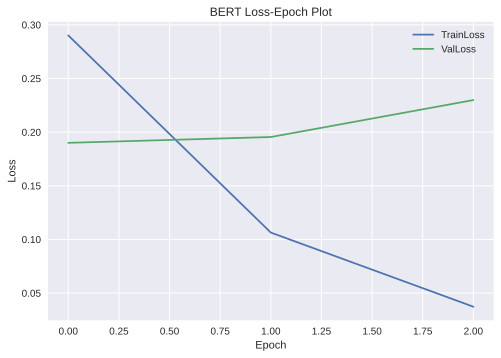

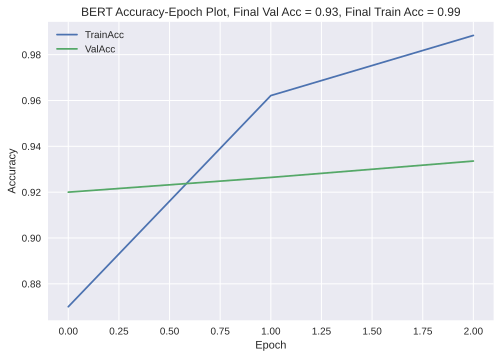

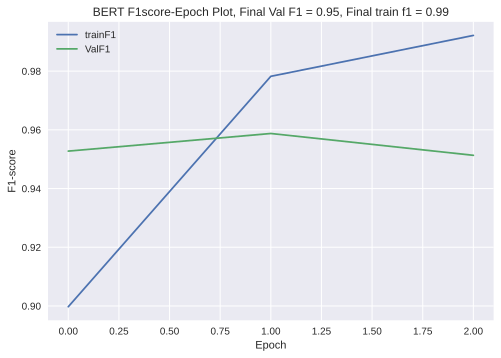

In [37]:
plotit_bert()